---
---
# Object Detection with YOLO
---
---

## Introduction
**This notebook will focus on Single-Stage Object Detectors for Object detection**

**Object detection** is a computer vision technique that involves identifying and locating objects within an image or video. Unlike image classification, where the task is to classify an entire image as belonging to a particular class, object detection aims to predict a bounding box and a class label for each object in the image. This makes it a more complex problem as it combines elements of both classification and localization.

Object detection has numerous practical applications, including self-driving cars (detecting pedestrians, vehicles), security systems (identifying threats), and many areas of automated visual data analysis.

### Categories of Object Detection Systems

Object detection systems can be categorized into:

1. **Two-Stage Detectors**: These, such as R-CNN and its variants, first generate regions of interest and then classify them. They are accurate but slow, making them less ideal for real-time applications.
2. **Single-Stage Detectors**: These skip the region proposal stage and directly predict bounding boxes and class labels, which speeds up the process and is suitable for real-time applications.

### Single-Stage Object Detectors

Single-stage detectors apply a single neural network to the entire image to directly predict bounding boxes and class probabilities. Examples include:

- **YOLO (You Only Look Once)**: Predicts bounding boxes and probabilities for each grid cell in the image using a single network pass.
- **SSD (Single Shot MultiBox Detector)**: Operates on multiple feature maps at different scales, using anchor boxes to improve detection across object sizes.

### Advantages of Single-Stage Detectors:

- **Speed**: They eliminate multiple stages typical in two-stage detectors, enabling faster processing.
- **Simplicity**: Fewer stages mean a simpler training and deployment pipeline.


## Libraries Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Loading Data

The **VOC Dataset** (Visual Object Classes) is a well-known dataset used in the field of computer vision, particularly for tasks such as object detection, classification, and image segmentation. It primarily features challenges like the PASCAL VOC Challenge, which has been influential in advancing the state of the art in object recognition algorithms. Here's a brief overview:
### Overview:
- **Objective:** The VOC Dataset challenges are designed to recognize objects from a number of visual object classes in realistic scenes (i.e., not pre-segmented objects).
- **Contents:** It includes images with objects categorized into classes, and each object in an image is annotated with a bounding box and a class label. Typical classes include vehicles, persons, animals, and indoor objects.
- **Tasks:** Predicting the class and bounding box of objects in images.
- **Years:** The dataset has several iterations, with VOC2007 and VOC2012 being the most commonly used. Each iteration introduces new images and annotations, with tasks sometimes varying slightly between iterations.

> ![VOC](https://www.researchgate.net/publication/318029536/figure/fig3/AS:510787866959875@1498792725870/Results-of-localization-on-PASCAL-VOC-dataset-17-Green-box-Estimated-Window-Red.png)

### Further Reading:
For more detailed information and to access the VOC Dataset, you can visit the following resources:
- [PASCAL VOC Homepage](http://host.robots.ox.ac.uk/pascal/VOC/): The official page of the VOC challenges, containing links to download the data, descriptions of the tasks, and results from various years.
- [VOC 2007 Challenge Results](http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html): Specific details about the 2007 challenge, including performance benchmarks and participant details.
- **Research Papers:**
  - Everingham, M., Van Gool, L., Williams, C.K.I., Winn, J., and Zisserman, A. "The PASCAL Visual Object Classes Challenge 2007 (VOC2007) Results."
  - This and other related papers outline the challenges, the dataset construction, and the methodologies used by participants, providing valuable insights into the evolution of object recognition technology.

In [ ]:
# Load the dataset
def load_data():
    (train_dataset, val_dataset), dataset_info = tfds.load(
        'voc/2007', split=['train', 'validation'], with_info=True, as_supervised=False)
    return train_dataset, val_dataset, dataset_info

# An initial Preprocess for the data
def preprocess_data(sample):
    image, data = sample['image'], sample['objects']
    image = tf.image.resize(image, (416, 416))  # Resize to YOLO input size
    return image, data

train_dataset, val_dataset, info = load_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Meta Data Understanding

In [ ]:
# print info using the meta data provided by the tfds
def print_dataset_info(dataset_info):
    print(f"Dataset Name: {dataset_info.name}")
    print(f"Full Name: {dataset_info.full_name}")
    print("Description:", dataset_info.description.strip())
    print("Configuration Description:", dataset_info.config_description.strip())
    print(f"Homepage: {dataset_info.homepage}")
    print(f"Data Directory: {dataset_info.data_dir}")
    print(f"File Format: {dataset_info.file_format}")
    print(f"Download Size: {dataset_info.download_size}")
    print(f"Dataset Size: {dataset_info.dataset_size}")
    print("\nFeatures:")
    for feature_name, feature_details in dataset_info.features.items():
        print(f"  {feature_name}: {feature_details}")
    print("\nSplits:")
    for split_name, split_details in dataset_info.splits.items():
        print(f"  {split_name.capitalize()}: {split_details.num_examples} examples in {split_details.num_shards} shards")
    print("\nCitation:\n", dataset_info.citation)

# Assuming dataset_info is already defined and populated
print_dataset_info(info)


Dataset Name: voc
Full Name: voc/2007/4.0.0
Description: This dataset contains the data from the PASCAL Visual Object Classes Challenge,
corresponding to the Classification and Detection competitions.

In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.
Configuration Description: 
Homepage: http://host.robots.ox.ac.uk/pascal/VOC/voc2007/
Data Directory: /tmp/tmpl01buv49tfds
File Format: FileFormat.TFRECORD
Download Size: 868.85 MiB
Dataset Size: 837.73 MiB

Features:
  image: Image(shape=(None, None, 3), dtype=uint8)
  image/filename: Text(shape=(), dtype=string)
  objects: Sequence({
    'bbox': BBoxFeature(shape=(4,), dtype=float32),
    'is_difficult': bool,
    'is_truncated': bool,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    'pose': ClassLabel(shape=(), dtype=int64, num_classes=5),
})
  

The output from your TensorFlow Datasets (TFDS) info provides a detailed structure of the dataset's features for the VOC 2007 dataset. Let's break down what each part means and how you can use this information:

### Features Dictionary Overview

The `FeaturesDict` object describes the schema of each entry in the dataset:

- **`image`**: This field holds the image itself. The shape `(None, None, 3)` indicates that the images can vary in height and width, and there are 3 channels (RGB). The dtype `uint8` suggests that pixel values range from 0 to 255.
  
- **`image/filename`**: This is a text field containing the filename of each image.

- **`labels`**: This is a sequence of labels, where each label corresponds to a class index associated with objects in the image. `ClassLabel(shape=(), dtype=int64, num_classes=20)` indicates there are 20 classes, and each label is an integer from 0 to 19.

- **`labels_no_difficult`**: Similar to `labels`, but it likely excludes objects marked as difficult for detection.

- **`objects`**: A sequence containing multiple fields for each object detected in the image:
  >- **`bbox`**: This `BBoxFeature` holds the bounding box information for an object in the image. The shape `(4,)` with dtype `float32` indicates each bounding box is represented by four float values. These typically are `(ymin, xmin, ymax, xmax)` normalized between 0 and 1 relative to the image dimensions.
  >- **`is_difficult`**: A boolean indicating whether the object is difficult to detect.
  >- **`is_truncated`**: A boolean indicating whether the object is truncated (partially out of the image frame).
  >- **`label`**: The class index of the object as `ClassLabel(shape=(), dtype=int64, num_classes=20)`.
  >- **`pose`**: A class label indicating the pose of the object with 5 possible values.


## Visualizing and Handling Bounding Boxes

**Handling Bounding Boxes**:
   The bounding boxes are given as `[ymin, xmin, ymax, xmax]` normalized.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Take one sample from the training set
for sample in train_dataset.take(1):
    image, filename, labels, labels_no_difficult, objects = (
        sample['image'],
        sample['image/filename'],
        sample['labels'],
        sample['labels_no_difficult'],
        sample['objects']
    )

    # Print the image filename for reference
    print(f"Filename: {filename.numpy().decode('utf-8')}")

    # Access the first object's bounding box and label
    first_bbox = objects['bbox'][0].numpy()
    first_label_index = objects['label'][0].numpy()

    # Get the label name using the label index
    first_label_name = info.features['objects']['label'].int2str(first_label_index)

    # Print the bounding box and label
    print("First bounding box: [ymin,         xmin,       ymax,      xmax  ]")
    print(f"First bounding box: {first_bbox}")
    print(f"Label index: {first_label_index}, Label name: {first_label_name}")


Filename: 007308.jpg
First bounding box: [ymin,         xmin,       ymax,      xmax  ]
First bounding box: [0.14375    0.0437018  0.97083336 0.7763496 ]
Label index: 12, Label name: horse


The following visualization helps in examining the accuracy of the object annotations within the images, ensuring that the bounding boxes are correctly placed and the right labels are assigned. This process is crucial for verifying data preprocessing in object detection tasks. Each bounding box is outlined in red, with the label text displayed at the top-left corner of the box, enhancing clarity and ease of review.

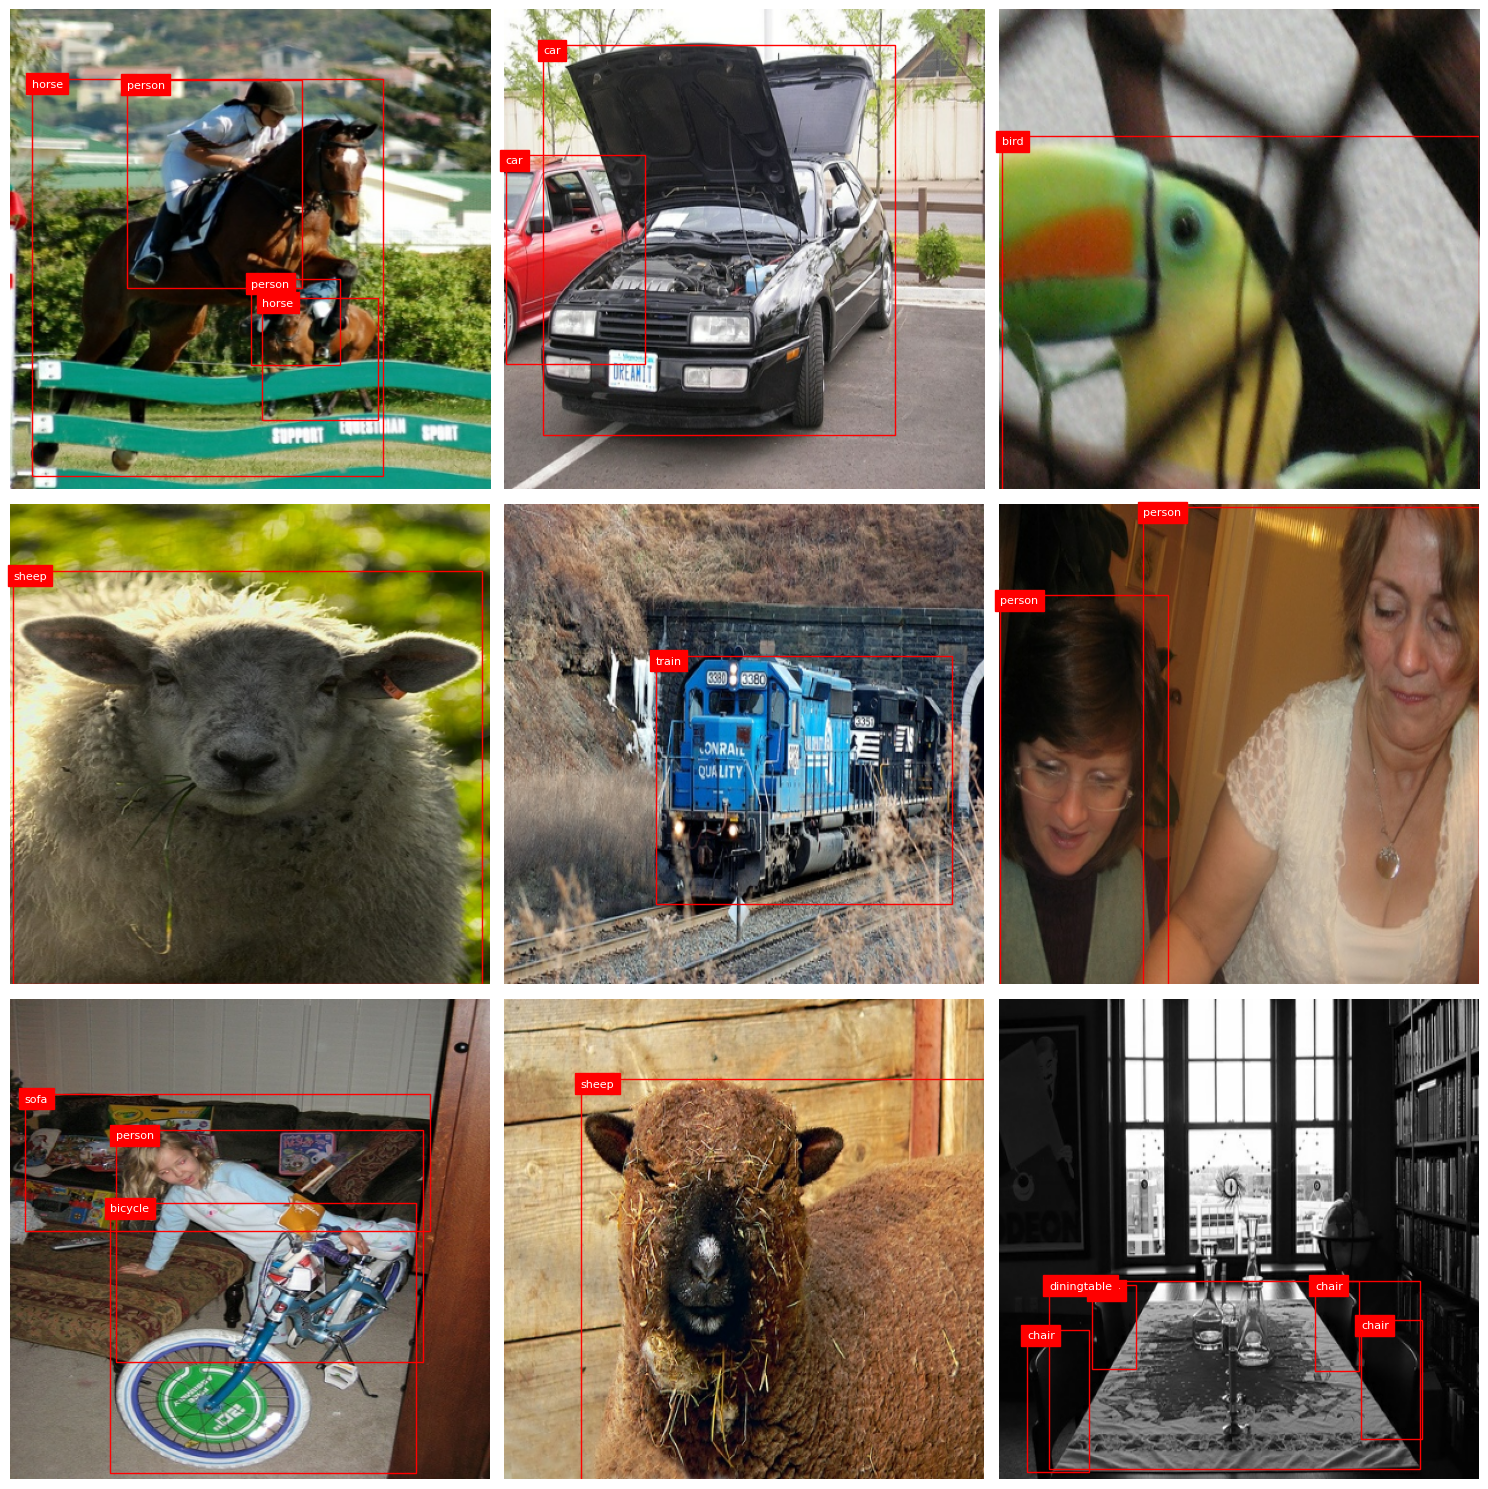

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

# Assuming 'info' is the dataset info that includes the label names
def get_label_name(label_index, info):
    return info.features['objects']['label'].int2str(label_index)

# Visualize the data with bounding boxes and label names
def visualize_data(batch, info):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Setting up a 3x3 grid of plots
    axs = axs.ravel()  # Flatten the array of axes for easy iteration

    for i, sample in enumerate(batch.take(9)):  # Only take 9 samples for the 3x3 grid
        image, data = preprocess_data(sample)
        axs[i].imshow(image.numpy().astype('uint8'))

        for bbox, label_index in zip(data['bbox'], data['label']):  # Assuming 'label' contains indices
            y_min, x_min, y_max, x_max = bbox
            label_name = get_label_name(label_index.numpy(), info)  # Convert index to label name
            rect = patches.Rectangle((x_min * 416, y_min * 416),
                                     (x_max - x_min) * 416,
                                     (y_max - y_min) * 416,
                                     linewidth=1, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)
            # Annotate the label at the top left corner of the bounding box
            axs[i].text(x_min * 416, y_min * 416, label_name,
                        verticalalignment='top', color='white', fontsize=8, backgroundcolor='red')

        axs[i].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

# Example usage, assuming 'train_dataset' and 'info' are defined
visualize_data(train_dataset, info)

## Modeling

### Introduction to KerasCV


KerasCV is a toolkit designed to enhance your experience in building computer vision models with Keras. It simplifies the creation, training, and scaling of robust, high-performance vision models by providing specialized tools and features.

#### Key Features of KerasCV

1. **Prebuilt Components**: Access a range of optimized layers and models for tasks like object detection, segmentation, and classification.
2. **Advanced Data Augmentation**: Employ sophisticated image transformations to train more robust models.
3. **Seamless TensorFlow Integration**: Benefit from TensorFlow's scalability and performance, with support for various hardware accelerators.
4. **Object Detection Tools**: Utilize utilities for bounding box management and COCO metrics for standardized evaluation.
5. **Advanced Training Techniques**: Implement cutting-edge training methods to enhance model capabilities.

#### Use Cases

- **Object Detection and Image Classification**: Build and fine-tune models for identifying and locating objects.
- **Image Segmentation**: Segment images into distinct parts for applications like medical imaging or autonomous driving.
- **Pose Estimation**: Detect the position and orientation of objects or individuals.

KerasCV is continuously updated, adding new features to help solve complex computer vision problems efficiently.

In [ ]:
!pip install -q keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.5 MB/s eta 0:00:00


In [ ]:
import keras_cv

Using TensorFlow backend


### Preprocessing

Now let's format our bounding boxes in a way that makes it easier to work with.

If you remember from our exploration of the data our bounding boxes are formated as `(ymin, xmin, ymax, xmax)`

To adhere to the **KerasCV API convention**, it's advisable that when crafting a custom data loader, you also accommodate a bounding_box_format argument. This ensures clarity for users invoking your data loader regarding the format of the bounding boxes. In our case, we format our boxes to the `'(x, y, width, height)` format.

In [ ]:
# let's override the old preprocessing data
def preprocess_data(sample, bounding_box_format= "xywh"):
    image = sample["image"]
    image = tf.image.resize(image, (640, 640))  # Resize to YOLO input size
    #image = image / 255.0 # rescale the image

    boxes = keras_cv.bounding_box.convert_format(
        sample["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": sample["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}

train_ds = train_dataset.map(preprocess_data).ragged_batch(4, drop_remainder=True)
eval_ds = val_dataset.map(preprocess_data).ragged_batch(4, drop_remainder=True)

### Visualize the dataset

Visualize the dataset to make sure the new boxes are correct

In [ ]:
# Get the label names from the metadata
label_names = info.features['labels'].names
label_names
class_ = dict(zip(range(len(label_names)), label_names))

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    keras_cv.visualization.plot_bounding_box_gallery(
              images,
              value_range=value_range,
              rows=rows,
              cols=cols,
              y_true=bounding_boxes,
              scale=5,
              font_scale=0.7,
              bounding_box_format=bounding_box_format,
              class_mapping=class_,
          )

And for the eval set:

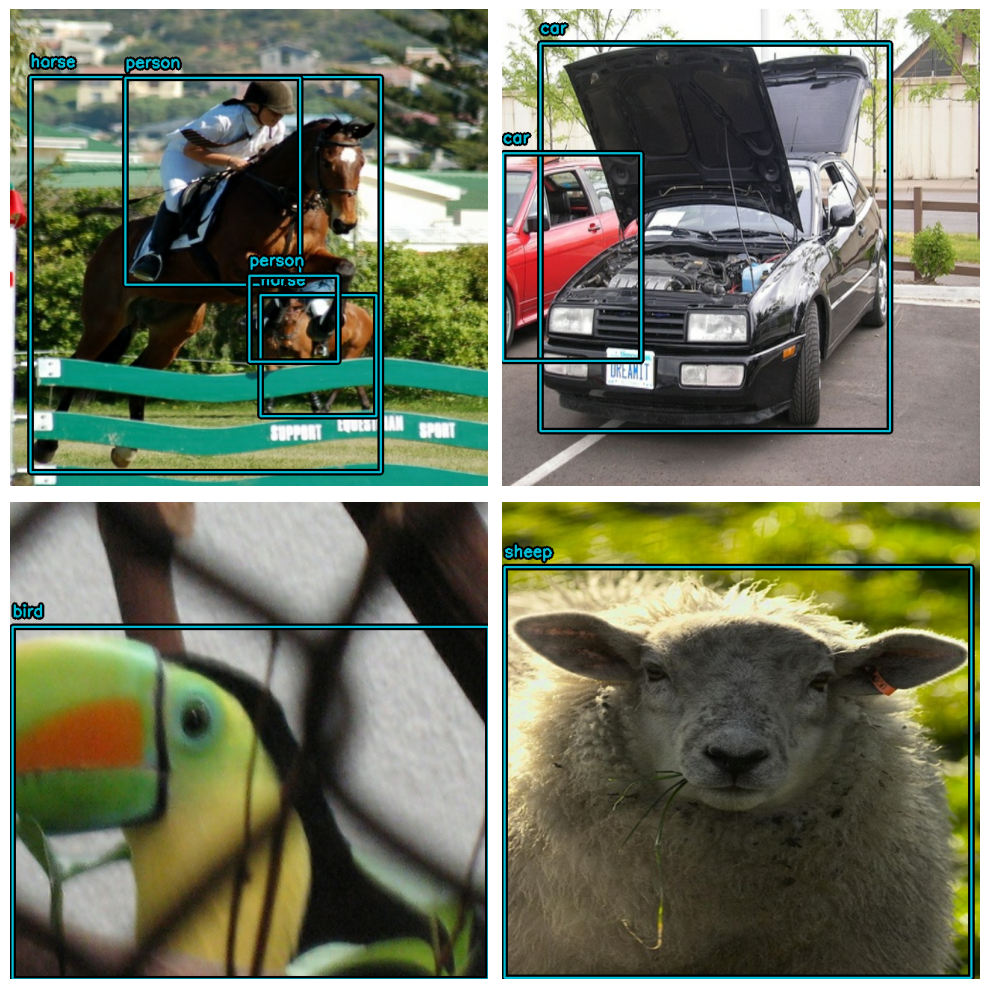

In [ ]:
visualize_dataset(train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2)

let's unpackage our inputs from the preprocessing dictionary, and
prepare to feed the inputs into our model.  In order to be TPU compatible,
bounding box Tensors need to be `Dense` instead of `Ragged`.

In [ ]:
from keras_cv import bounding_box

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)


## Building the Model

Now, we'll take advantage of the KerasCV API to build an untrained YOLOV8Detector model. For this tutorial, we'll incorporate a pretrained yolo_v8_m_backbone_coco backbone, sourced from the [COCO](https://cocodataset.org/) dataset.

KerasCV simplifies the process of constructing a `YOLOV8Detector`. You can easily integrate any KerasCV backbone by selecting from the preset architectures available!

# Understanding the YOLO Algorithm

YOLO (You Only Look Once) is a state-of-the-art, real-time object detection system, initially introduced in a 2015 paper by Joseph Redmon et al. Unlike other detection systems that apply the model to various locations and scales of an image (typically done in a sliding window fashion), YOLO frames object detection as a single regression problem, straight from image pixels to bounding box coordinates and class probabilities.

In [ ]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_backbone_coco",
    bounding_box_format="xywh",
    num_classes=20,
)

100%|██████████| 646/646 [00:00<00:00, 340kB/s]
100%|██████████| 45.6M/45.6M [00:01<00:00, 42.9MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids



## How YOLO Works:

1. **Single Neural Network:** YOLO uses a single convolutional neural network (CNN) to predict multiple bounding boxes and class probabilities for those boxes simultaneously. This single model approach makes it extremely fast.

2. **Grid System:** The image is divided into an SxS grid and for each grid cell, the model predicts B bounding boxes, confidence for those boxes, and C class probabilities. Confidence reflects the accuracy of the bounding box and whether the box actually contains a specific object. The class probabilities denote the likelihood of each class being present in a box, given that there is an object.

3. **Prediction:** At test time, the network predicts multiple bounding boxes per grid cell, and through the use of confidence scores, it can determine the most probable box for each detected object. Non-max suppression can be used to refine these boxes further, reducing overlaps and defining the precise object locations.


That is all it takes to construct a KerasCV YOLOv8. The YOLOv8 accepts
tuples of dense image Tensors and bounding box dictionaries to `fit()` and
`train_on_batch()`

This matches what we have constructed in our input pipeline above.

## Training the Model

Now, the only step remaining is to train our model. KerasCV object detection models utilize the standard Keras workflow, which includes using the `compile()` and `fit()` methods.

Let's go ahead and compile our model:

In [ ]:

model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer='adam',
)

## Object Detection Metrics

The primary metrics for object detection are the COCO metrics, associated with the MSCOCO dataset. KerasCV offers these metrics through the `keras_cv.callbacks.PyCOCOCallback`. Unlike typical Keras metrics, COCO metrics are computed using a Keras callback because they require all model predictions for the evaluation dataset to be stored in memory simultaneously, which isn't feasible during training.

In [ ]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)

In [ ]:
coco_metrics_callback

Certainly! Here’s a simplified and more explanatory version of the description on COCO metrics and the PyCOCOCallback:

---

### Understanding COCO Metrics and PyCOCOCallback

COCO metrics come from the Common Objects in Context (COCO) dataset, a key resource for testing object detection, segmentation, and captioning algorithms. These metrics are vital for evaluating how well object detection models perform.

#### Explaining COCO Metrics:

COCO uses several metrics to measure the effectiveness of object detection models:

**Average Precision (AP):** This metric assesses the accuracy of object identification. It calculates how precisely a model can detect objects across various difficulty levels, expressed as recall values from 0 to 1. Here's how it's broken down:
   - **AP@IoU=0.50:** Measures precision when the overlap between the predicted bounding box and the true box is at least 50%. This is known as Intersection over Union (IoU), a common metric to evaluate how well two areas overlap.
   - **AP@IoU=0.75:** This is similar but requires a 75% overlap, indicating a stricter precision measure.
   - **AP@IoU=0.50:0.95:** This is an average of the precision scores calculated for IoU thresholds from 50% to 95%, stepping by 5%. It gives a comprehensive view of model precision across a range of tolerances.
   
**Intersection over Union (IoU)** is a metric used in computer vision to measure the accuracy of object detection. It calculates the overlap between a predicted bounding box and a ground truth bounding box by dividing the area of overlap by the area of union of both boxes. This ratio, ranging from 0 (no overlap) to 1 (perfect overlap), helps evaluate how well a model predicts the location of objects.. Here’s how it's generally visualized:

>- **Overlap Area:** This is the area where the predicted bounding box and the true bounding box intersect or overlap.
>- **Union Area:** This is the total area covered by both the predicted bounding box and the true bounding box, including the overlap area.

**Average Recall (AR):** AR measures the model's ability to find all relevant objects within an image, with a cap on the number of detections:
   - **AR@1:** The maximum recall possible with just one prediction per image.
   - **AR@10:** The maximum recall possible with up to ten predictions per image.
   - **AR for small, medium, and large objects:** Evaluates how well the model detects objects of different sizes, which is crucial for applications like autonomous driving, where detecting objects of various sizes accurately is key.

These metrics help in understanding the strengths and limitations of object detection models, guiding improvements and ensuring they perform well in real-world conditions.

In [ ]:
model.fit(
    train_ds.take(20),
    epochs=1,
    callbacks=[coco_metrics_callback],
)

20/20 [==============================] - 7s 135ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ 


## Advantages of YOLO:

- **Speed:** As the name suggests, YOLO only looks once at the image, which makes it incredibly faster than other detection systems where each part of the image needs to be looked at separately.

- **Accuracy:** YOLO achieves high accuracy while also being able to generalize well from natural images, making it robust against varied and new environments.

- **Real-time Processing:** Its ability to process images in real-time opens up numerous applications in areas like video surveillance, self-driving cars, and real-time threat detection.

## Challenges:

- **Limitations on Localization:** Due to its grid-based system, YOLO might struggle with small objects or objects in groups, as only a certain number of objects can be detected per grid.

- **Trade-offs:** There is a trade-off between speed and accuracy, particularly noticeable in earlier versions. Later iterations, like YOLOv3 and YOLOv4, have significantly improved in these aspects.

YOLO has undergone several improvements since its first release, leading to various versions like YOLOv2, YOLOv3, YOLOv4, and YOLOv5, each enhancing both speed and detection accuracy. It remains one of the most popular choices for real-time object detection in computer vision./

## Inference and plotting results

Next, for convenience we construct a dataset with larger batches:

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)

Let's create a simple function to plot our inferences:

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_,
    )


You may need to configure your NonMaxSuppression operation to achieve
visually appealing results.

### Non-Maximum Suppression
Non-Maximum Suppression (NMS) is a crucial technique used in object detection tasks to prune multiple bounding boxes predicting the same object down to the best one. This method helps in reducing redundancy among the detected bounding boxes and ensures that each detected object is represented by only one bounding box.

![Non-Maximum](https://miro.medium.com/v2/resize:fit:1200/1*6d_D0ySg-kOvfrzIRwHIiA.png)

### How Non-Maximum Suppression Works:

1. **Score Sorting**: All the predicted bounding boxes are initially sorted based on their confidence scores, which indicate the likelihood of an object being present in the bounding box.

2. **Selecting the Best Box**: The bounding box with the highest score is selected and all other bounding boxes that have a high overlap (as measured by Intersection over Union (IoU)) with this box are suppressed.

3. **Thresholding IoU**: IoU is a metric used to quantify the percent overlap between two bounding boxes. It is calculated as the area of overlap between two bounding boxes divided by the area of union (or the total area covered by both bounding boxes). NMS uses a predefined threshold to determine how much overlap is permissible. If the IoU between a candidate box and the selected box exceeds this threshold, the candidate box is suppressed.

4. **Iterating**: This process is repeated for the remaining boxes, and in each iteration, the next box with the highest score that has not been suppressed is selected. This continues until all boxes are either selected or suppressed.

1/1 [==============================] - 3s 3s/step


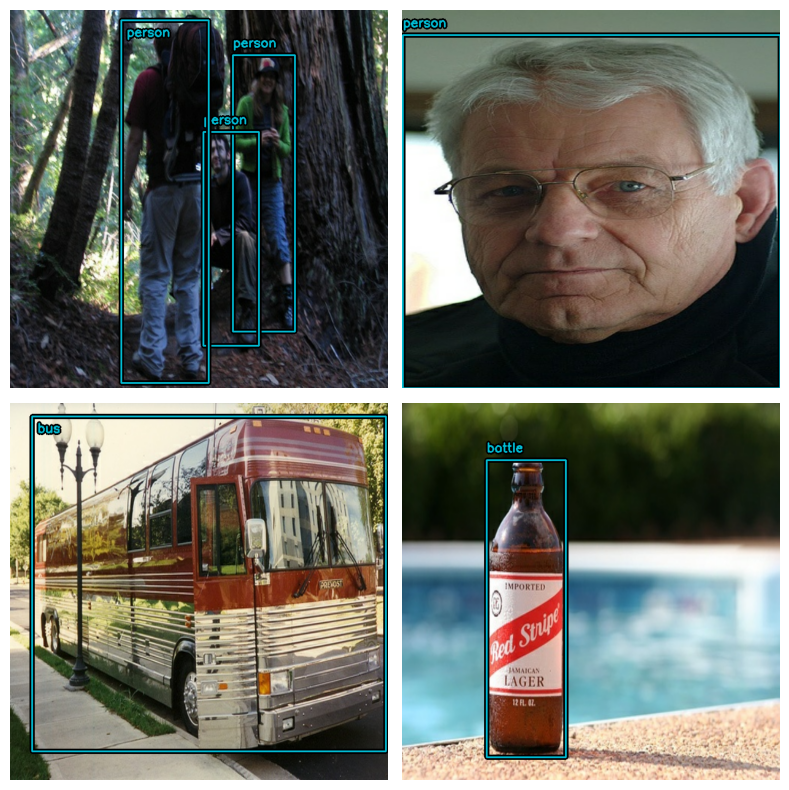

In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")